# Braket Sparse State Cost Benchmark

In `QSP_method_call_demo.ipynb` and `QSP_detailed_implementation.ipynb`, we mostly consider dense states (i.e., all coeffcients $x_i$'s have non-zero values). In this notebook, we will benchmark the required multi-control rotation gates for sparse states (i.e., only $d << 2^n$ coefficients are non-zero).

$$U_{\mathrm{QSP}} |0^n\rangle = |\psi\rangle = \frac{1}{\lVert \mathbf{x}\rVert}\sum_{i=0}^{d}x_i |i\rangle, x_i \in \mathbb{C}$$

See https://github.com/guikaiwen/qubit_efficient_QSP/blob/main/performance_benchmark/qiskit_sparse_state_gate_count.ipynb for the gate count benchmark on Qiskit's built-in `.initialize()` function.

### Worst Case Upper Bound

For each additional added non-zero amplitude, at most $n$ zero values are turned into non-zero values in the amplitude-to-angle equation $\beta_j^s = 2\,\text{arcsin}\Bigg(\frac{\sqrt{\sum_{l=0}^{2^{s-1} - 1}|a_{(2j-1)2^{s-1}+l}|^2}}{\sqrt{\sum_{l=0}^{2^{s}-1}|a_{(j-1)2^{s}+l}|^2}}\Bigg)$. We can see that for any $j_p$ $\neq$ $j_q$, the summation on the numerator has distinct coverage of $a$ value indices. Therefore, for each additional non-zero value, at most $1$ non-zero value will be incurred for the each $s^{\mathrm{th}}$ layer, thus in total at most $n$ non-zero $\beta_j^s$ values will be incurred (since $s$ ranges from $0$ to $n - 1$). 

To translate to the gate language, each additional non-zero amplitude will incurr at most $n$ additional multi-control Ry gates. Therefore, for $d$ non-zero values on the amplitude, we need at most $nd$ multi-control Ry gates.

Since there is no meaning for adding complex phase on zero amplitude values, we also have a $nd$ gate count upper bound for the Rz gate.

### Average Case Benchmark

In practice, the average case cost can be better than the worse case cost, let's see how the average cast looks like.

In [1]:
import numpy as np
import random
import math
import itertools

from helper_functions import *
from qsp_circ_construction_qubit_efficient import compute_ry_rotation_angle

We can define a method to count the number of required rotations. If the rotation angle is computed to be $0$, we don't need to invoke the multi-control gate instruction, which would save a lot of the gate costs.

In [2]:
def count_non_zero_rotations(normalized_sparse_real_array: np.ndarray, tolerance = 1e-10) -> int:
    """
    Function to count the number of non-zero rotation angles
    
    @param normalized_sparse_real_array: the entire wave function array vector values to be encoded
    @tolerance: a float number to decide if the computed angle is close enough to be treated as 0
    
    @return: a int that holds the non-zero angle count
    """
    n = int(math.log2(len(normalized_sparse_real_array)))
    count = 0
    for s in range(n, 0, -1): # as it exactly defined in the figure above
            for j in range(2 ** (n - s), 0, -1):
                if compute_ry_rotation_angle(s, j, normalized_sparse_real_array) > tolerance:
                    count += 1
    return count

#### Iterate Through All Possible Sparse States

We can use a brute force method to iterate through all the combinations of the appearance of non-zero value indices:

In [3]:
def get_combinations(n: int, d: int):
    if d > n:
        print("Invalid input. 'd' must be less than or equal to 'n'.")
        return []

    elements = list(range(n + 1))
    combinations = list(itertools.combinations(elements, d))
    return [list(combo) for combo in combinations]

For example, we can set some small values are see all the possible combinations:

In [4]:
n = 2
d = 2

combinations = get_combinations(2 ** n - 1, d)
for combo in combinations:
    print(combo)

[0, 1]
[0, 2]
[0, 3]
[1, 2]
[1, 3]
[2, 3]


These arrays will then represent the non-zero coefficient positions in the input arrays.

Now back to some larger numbers, we can get the average non-zero angle counts and the max angle counts for this particular set of $(n, d)$

In [5]:
n = 5
d = 3
combinations = get_combinations(2 ** n - 1, d)
count_array = []
for combo in combinations:
    w_like_state = generate_normalized_real_sparse_array(n, combo)
    count_array.append(count_non_zero_rotations(w_like_state))
# print(count_array)
print('The mean count is ' + str(np.mean(count_array)))
print('The max count is ' + str(np.max(count_array)))
print('We have ' + str(len(count_array)) + ' combinations')

The mean count is 6.380645161290323
The max count is 12
We have 4960 combinations


Plot it, looks like a normal distrbution.

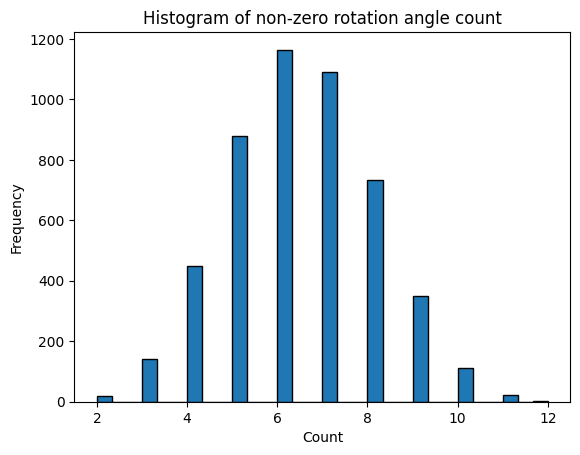

In [6]:
import matplotlib.pyplot as plt

plt.hist(count_array, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title("Histogram of non-zero rotation angle count")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

Iterate through different $n$ values while fixing $d$:

In [7]:
n_array = []
mean_array = []
max_array = []
for n in range(3, 7):
    d = 3
    combinations = get_combinations(2 ** n - 1, d)
    count_array = []
    for combo in combinations:
        w_like_state = generate_normalized_real_sparse_array(n, combo)
        count_array.append(count_non_zero_rotations(w_like_state))
    n_array.append(n)
    mean_array.append(np.mean(count_array))
    max_array.append(np.max(count_array))
    print('for n = ' + str(n))
    print('The mean count is ' + str(np.mean(count_array)))
    print('The max count is ' + str(np.max(count_array)))
    print('We have ' + str(len(count_array)) + ' combinations')
    print()

for n = 3
The mean count is 3.7142857142857144
The max count is 6
We have 56 combinations

for n = 4
The mean count is 5.014285714285714
The max count is 9
We have 560 combinations

for n = 5
The mean count is 6.380645161290323
The max count is 12
We have 4960 combinations

for n = 6
The mean count is 7.7949308755760365
The max count is 15
We have 41664 combinations



Plot it:

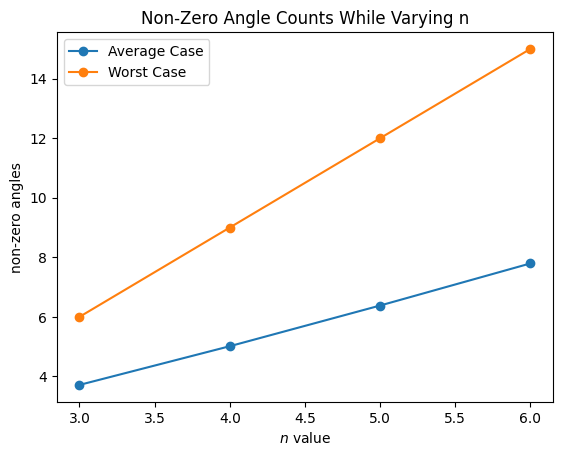

In [8]:
fig, ax = plt.subplots()
ax.plot(n_array, mean_array, label='Average Case', marker='o')  # Plot some data on the axes.
ax.plot(n_array, max_array, label='Worst Case', marker='o')  # Plot some data on the axes.
ax.set_xlabel('$n$ value')  # Add an x-label to the axes.
ax.set_ylabel('non-zero angles')  # Add a y-label to the axes.
ax.set_title("Non-Zero Angle Counts While Varying n")  # Add a title to the axes.
ax.legend()  # Add a legend.

We can see that the average case scale roughly half as the worst case.

#### Sample Sparse States for larger $n$ and $d$ Instances

We can also try to sample some combinations if $(n, d)$ gets larger (since iterating through all possible combinations has exponential complexity and thus not scalable):

In [9]:
n = 7
d = 3
max_iter = 10
count_array = []
for _ in range(max_iter):
    result = sorted(random.sample(range(2 ** n), d))
    print(result)

[2, 39, 80]
[23, 94, 110]
[61, 66, 113]
[42, 83, 109]
[17, 34, 97]
[27, 78, 109]
[42, 89, 96]
[87, 102, 117]
[11, 27, 84]
[29, 37, 50]


Now sample 1000 combinations for $n = 9$ and $d = 3$ and get the non-zero rotation angles for each of the samples index array:

In [10]:
n = 9
d = 3
max_iter = 1000
count_array = []
for _ in range(max_iter):
    result = sorted(random.sample(range(2 ** n), d))
    w_like_state = generate_normalized_real_sparse_array(n, result)
    count_array.append(count_non_zero_rotations(w_like_state))
print(np.mean(count_array))
print(np.max(count_array))

12.237
19


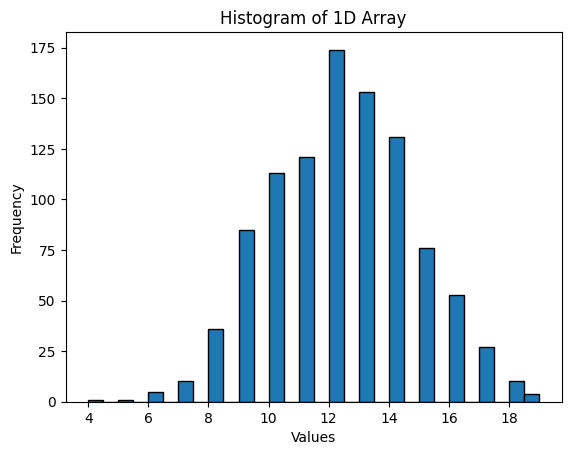

In [11]:
plt.hist(count_array, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title("Histogram of 1D Array")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

So, how does the non-zero angle count behave as n and d scales up?

Let's first do a case for different $n$ values while fixing $d = 6$:

In [12]:
n_array = []
mean_array = []
max_array = []
for n in range(4, 13):
    d = 6
    max_iter = 1000
    count_array = []
    for _ in range(max_iter):
        result = sorted(random.sample(range(2 ** n), d))
        w_like_state = generate_normalized_real_sparse_array(n, result)
        count_array.append(count_non_zero_rotations(w_like_state))
    n_array.append(n)
    mean_array.append(np.mean(count_array))
    max_array.append(np.max(count_array))
# print(n_array)
print(mean_array)
print(max_array)

[8.195, 10.862, 13.495, 16.315, 19.045, 22.204, 24.962, 27.792, 31.01]
[12, 17, 20, 25, 29, 32, 37, 38, 44]


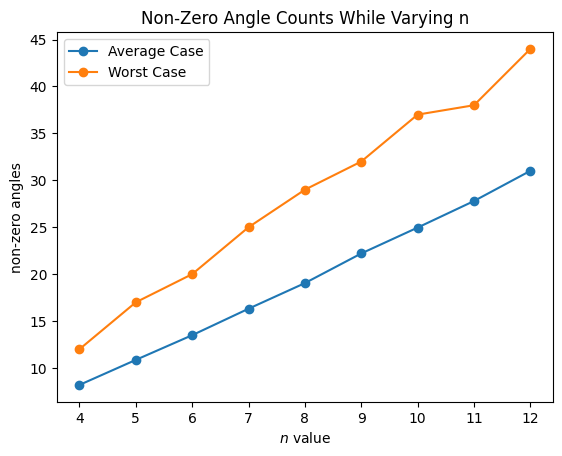

In [13]:
fig, ax = plt.subplots()
ax.plot(n_array, mean_array, label='Average Case', marker='o')  # Plot some data on the axes.
ax.plot(n_array, max_array, label='Worst Case', marker='o')  # Plot some data on the axes.
ax.set_xlabel('$n$ value')  # Add an x-label to the axes.
ax.set_ylabel('non-zero angles')  # Add a y-label to the axes.
ax.set_title("Non-Zero Angle Counts While Varying n")  # Add a title to the axes.
ax.legend()  # Add a legend.

<span style="color:orange;"> Note: the worst case is not the ACTUAL worst case but only the worst case in the sample states, since we have a relatively low chance of sampling on that actual one </span>

Now do another case for different d values while fixing $n = 8$

In [14]:
d_array = []
mean_array = []
max_array = []
for d in range(4, 13):
    n = 8
    max_iter = 1000
    count_array = []
    for _ in range(max_iter):
        result = sorted(random.sample(range(2 ** n), d))
        w_like_state = generate_normalized_real_sparse_array(n, result)
        count_array.append(count_non_zero_rotations(w_like_state))
    d_array.append(d)
    mean_array.append(np.mean(count_array))
    max_array.append(np.max(count_array))
# print(n_array)
print(mean_array)
print(max_array)

[13.754, 16.612, 18.904, 21.671, 24.074, 26.486, 28.77, 31.288, 33.055]
[23, 25, 27, 33, 34, 38, 40, 46, 47]


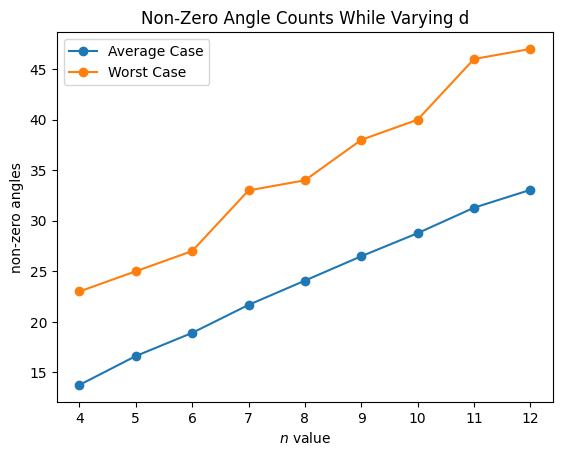

In [15]:
fig, ax = plt.subplots()
ax.plot(n_array, mean_array, label='Average Case', marker='o')  # Plot some data on the axes.
ax.plot(n_array, max_array, label='Worst Case', marker='o')  # Plot some data on the axes.
ax.set_xlabel('$n$ value')  # Add an x-label to the axes.
ax.set_ylabel('non-zero angles')  # Add a y-label to the axes.
ax.set_title("Non-Zero Angle Counts While Varying d")  # Add a title to the axes.
ax.legend()  # Add a legend.

[For Alex's reference only] We can see that the overall gate count complexity is roughly linear to both $n$ and $d$, thus bring us to $O(nd)$ total gate complexity. Since we have qubit complexity of $O(n)$, this will bring us a $O(n^2d)$ spacetime allocation. The Zhang et al. paper has achieved $\Theta(\log(nd))$ with $O(nd\log(d))$ ancilla qubits for arbitrary d-sparse states, which would result in $O(nd\log(nd)\log(d))$ spacetime allocation. For near term simulation (e.g., number of qubit is limited), this difference probably won't matter that much, not to mention that the dense case is not theoretically optimal anyway. Maybe one day someone can try attempt the Sun et al. method and see how the performance compares when the constants are factored in.

In [16]:
import sys
print(sys.version)

3.10.11 (main, May 17 2023, 14:30:36) [Clang 14.0.6 ]
